# Extract knowledge from raster data

In [312]:
import os
import numpy as np
import rasterio
from scipy.ndimage import sobel
import matplotlib.pyplot as plt
import pandas as pd

def extract_basic_stats(tiff_path):
    with rasterio.open(tiff_path) as src:
        elevation_data = src.read(1)
        elevation_data = elevation_data[elevation_data != src.nodata]
    
    mean_elevation = np.mean(elevation_data)
    min_elevation = np.min(elevation_data)
    max_elevation = np.max(elevation_data)

    return mean_elevation, min_elevation, max_elevation

def calculate_slope_aspect(tiff_path):
    with rasterio.open(tiff_path) as src:
        elevation_data = src.read(1)
        elevation_data[elevation_data == src.nodata] = np.nan
    
    if elevation_data.ndim != 2 or np.isnan(elevation_data).all():
        print(f"Invalid or empty elevation data in {tiff_path}")
        return np.zeros((1, 1)), np.zeros((1, 1))
    
    elevation_data = np.nan_to_num(elevation_data, nan=np.nanmedian(elevation_data))
    
    dx = sobel(elevation_data, axis=1)
    dy = sobel(elevation_data, axis=0)

    slope = np.sqrt(dx**2 + dy**2)
    aspect = np.arctan2(dy, dx)
    
    return slope, aspect

def calculate_flat_area_percentage(slope, threshold=10):
    flat_area = np.sum(slope < threshold)
    total_area = slope.size
    flat_percentage = (flat_area / total_area) * 100
    return flat_percentage

def determine_terrain_type(mean_elevation, min_elevation, max_elevation, flat_percentage):
    elevation_range = max_elevation - min_elevation
    if flat_percentage > 90 and elevation_range < 50:
        return "Równina"
    elif flat_percentage > 70 and elevation_range < 100:
        return "Płaskowyż"
    elif mean_elevation < (min_elevation + max_elevation) / 2:
        return "Kotlina"
    elif elevation_range > 200:
        return "Góry/Wyżyna"
    else:
        return "Nieokreślony"

def process_elevation_data(tiff_path):
    mean_elev, min_elev, max_elev = extract_basic_stats(tiff_path)
    slope, aspect = calculate_slope_aspect(tiff_path)
    flat_percentage = calculate_flat_area_percentage(slope)
    terrain_type = determine_terrain_type(mean_elev, min_elev, max_elev, flat_percentage)

    return {
        "srednia_wysokosc": mean_elev,
        "min_wysokosc": min_elev,
        "max_wysokosc": max_elev,
        "procent_plaski": flat_percentage,# ,
        # "ekspozycja": aspect
        # "typ_terenu": terrain_type,
    }

def process_all_tiff_files(directory):
    results = {}
    for tiff_file in os.listdir(directory):
        if tiff_file.endswith(".tiff"):
            station_name = tiff_file.replace("downsampled_NMT_", "").replace(".tiff", "")
            tiff_path = os.path.join(directory, tiff_file)
            results[station_name] = process_elevation_data(tiff_path)
    return results

    station_name  srednia_wysokosc  min_wysokosc  max_wysokosc  procent_plaski
0      BIALYSTOK        147.612198    127.860001    166.889999         98.9028
1  BIELSKO-BIALA        371.158417    307.344696    523.453979         88.0808
2      BYDGOSZCZ         70.682144     32.509998     84.889999         98.4796
3       CHOJNICE        159.156998    120.290001    201.330002         92.7516
4    CZESTOCHOWA        262.697784    243.546158    299.676514         98.0228


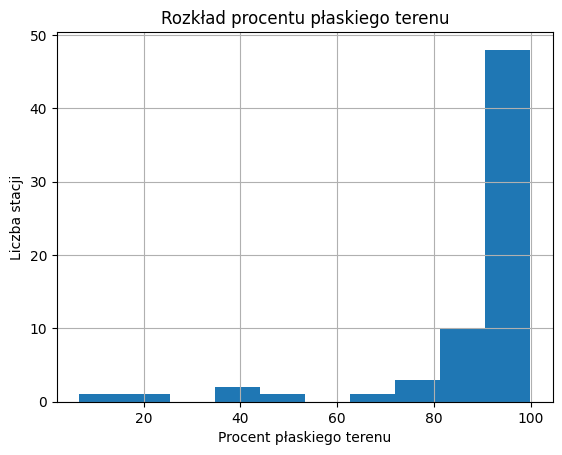

In [313]:
tiff_directory = "data/geoportal/downsampled"

results = process_all_tiff_files(tiff_directory)

results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={"index": "station_name"}, inplace=True)
results_df.to_csv("outputFiles/features/elevation_features.csv", index=False)

print(results_df.head())

results_df['procent_plaski'].hist(bins=10)
plt.title('Rozkład procentu płaskiego terenu')
plt.xlabel('Procent płaskiego terenu')
plt.ylabel('Liczba stacji')
plt.show()


# Import weather data

In [314]:

weather_df = pd.read_csv('outputFiles/features/weather_features.csv', encoding='utf-8')

dict_names = {
    "BIELSKO-BIA�A": "BIELSKO-BIALA",
    "HALA G�SIENICOWA": "HALA GASIENICOWA",
    "NOWY S�CZ": "NOWY SACZ",
    "JELENIA G�RA": "JELENIA GORA",
    "�NIE�KA": "SNIEZKA",
    "K�ODZKO": "KLODZKO",
    "RACIB�RZ": "RACIBORZ",
    "CZ�STOCHOWA": "CZESTOCHOWA",
    "KRAK�W-BALICE": "KRAKOW-BALICE",
    "KIELCE-SUK�W": "KIELCE-SUKOW",
    "TARN�W": "TARNOW",
    "RZESZ�W-JASIONKA": "RZESZOW-JASIONKA",
    "ZAMO��": "ZAMOSC",
    "ZIELONA G�RA": "ZIELONA GORA",
    "WROC�AW-STRACHOWICE": "WROCLAW-STRACHOWICE",
    "WIELU�": "WIELUN",
    "��D�-LUBLINEK": "LODZ-LUBLINEK",
    "SULEJ�W": "SULEJOW",
    "S�UBICE": "SLUBICE",
    "GORZ�W WIELKOPOLSKI": "GORZOW WIELKOPOLSKI",
    "W�ODAWA": "WLODAWA",
    "POZNA�-�AWICA": "POZNAN-LAWICA",
    "KO�O": "KOLO",
    "P�OCK": "PLOCK",
    "WARSZAWA-OK�CIE": "WARSZAWA-OKLCIE",
    "�WINOUJ�CIE": "SWINOUJSCIE",
    "RESKO-SM�LSKO": "RESKO-SMOLSKO",
    "PI�A": "PILA",
    "TORU�": "TORUN",
    "M�AWA": "MLAWA",
    "MIKO�AJKI": "MIKOLAJKI",
    "BIA�YSTOK": "BIALYSTOK",
    "KO�OBRZEG-D�WIRZYNO": "KOLOBRZEG-DZWIRZYNO",
    "�EBA": "LEBA",
    "L�BORK": "LEBORK",
    "GDA�SK-�WIBNO": "GDANSK-SWIBNO",
    "ELBL�G-MILEJEWO": "ELBLAG-MILEJEWO",
    "K�TRZYN": "KETRZYN",
    "SUWA�KI": "SUWALKI",
    "KRAK�W": "KRAKOW"
}

weather_df["Nazwa_stacji"] = weather_df["Nazwa_stacji"].replace(dict_names)

weather_df.to_csv("outputFiles/features/weather_features.csv", index=False, encoding='utf-8')

In [315]:
weather_df.head()

,Kod_stacji,Nazwa_stacji,Miesiac,Absolutna_temperatura_maksymalna,Srednia_temperatura_maksymalna,Absolutna_temperatura_minimalna,Srednia_temperatura_minimalna,Srednia_temperatura_miesieczna,Minimalna_temperatura_przy_gruncie,Miesieczna_suma_opadow,Maksymalna_dobowa_suma_opadow,Miesieczna_suma_uslonecznienia,Liczba_dni_z_opadem_deszczu,Srednia_miesieczna_predkosc_wiatru,Srednie_miesieczne_cisnienie_na_poziomie_stacji,Srednia_miesieczna_wilgotnosc_wzgledna
0,349190600,BIELSKO-BIALA,1,18.0,5.3,-6.2,1.0,3.1,-9.8,86.8,14.2,61.5,9,4.0,968.6,80.7
1,349190600,BIELSKO-BIALA,2,11.1,4.6,-14.1,-1.7,1.4,-18.7,49.9,13.3,0.0,9,4.3,975.5,77.7
2,349190600,BIELSKO-BIALA,3,18.6,10.1,-9.1,1.5,5.6,-13.9,38.0,6.8,0.0,11,4.6,963.8,66.1
3,349190600,BIELSKO-BIALA,4,20.9,11.7,-6.0,3.1,7.1,-7.3,56.1,10.7,146.2,13,2.8,967.9,72.7
4,349190600,BIELSKO-BIALA,5,23.9,17.3,0.6,7.3,12.4,-1.3,109.9,33.1,214.0,11,2.9,972.7,71.2


# Join data

In [316]:
weather_df['Nazwa_stacji_norm'] = weather_df['Nazwa_stacji'].str.upper().str.replace(' ', '').str.replace('-', '').str.replace('Ł', 'L').str.replace('Ó', 'O')
results_df['station_name_norm'] = results_df['station_name'].str.upper().str.replace(' ', '').str.replace('-', '').str.replace('Ł', 'L').str.replace('Ó', 'O')

merged_df = pd.merge(weather_df, results_df, left_on='Nazwa_stacji_norm', right_on='station_name_norm', how='left')

merged_df.drop(columns=['Nazwa_stacji_norm', 'station_name_norm', 'station_name'], inplace=True)

merged_df.to_csv("outputFiles/features/elevation_weather_joined.csv", index=False)

print(merged_df.head())

   Kod_stacji   Nazwa_stacji  Miesiac  Absolutna_temperatura_maksymalna  \
0   349190600  BIELSKO-BIALA        1                              18.0   
1   349190600  BIELSKO-BIALA        2                              11.1   
2   349190600  BIELSKO-BIALA        3                              18.6   
3   349190600  BIELSKO-BIALA        4                              20.9   
4   349190600  BIELSKO-BIALA        5                              23.9   

   Srednia_temperatura_maksymalna  Absolutna_temperatura_minimalna  \
0                             5.3                             -6.2   
1                             4.6                            -14.1   
2                            10.1                             -9.1   
3                            11.7                             -6.0   
4                            17.3                              0.6   

   Srednia_temperatura_minimalna  Srednia_temperatura_miesieczna  \
0                            1.0                            

# Korelacja

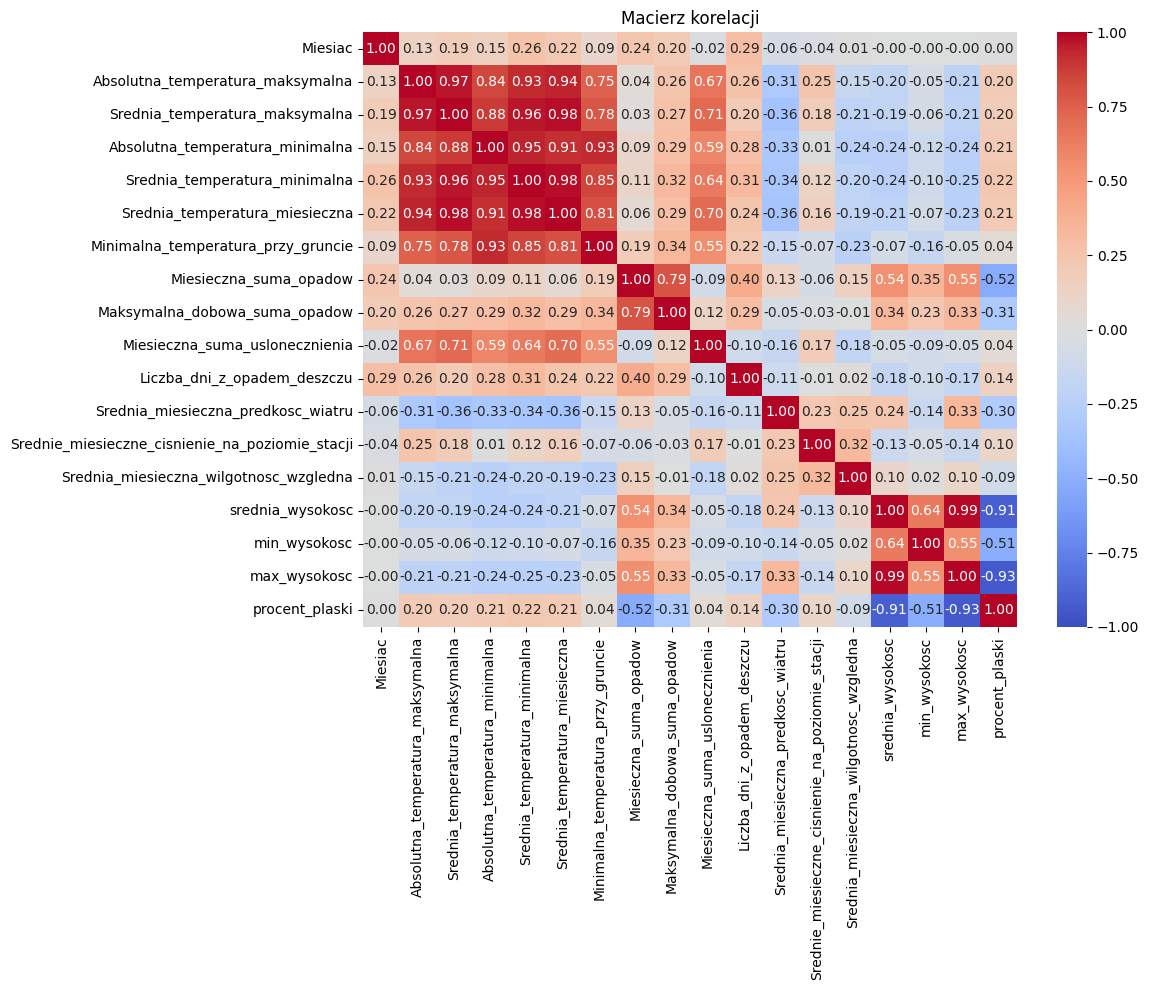

In [317]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

numeric_data = merged_df.copy().drop(columns=['Kod_stacji', 'Nazwa_stacji'])

correlation_matrix = numeric_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Macierz korelacji")
plt.tight_layout()
plt.savefig(os.path.join('outputFiles/plots', f"correlation_matrix_joined.png"))
plt.show()

# Klasteryzacja - 12 rekordów per stacja

In [318]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

merged_df = merged_df[merged_df['Miesiac'] == 4]
num_cols = merged_df.select_dtypes(include='number').columns
X = merged_df[num_cols].dropna()
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# DBSCAN

Best DBSCAN params: {'eps': 2.0999999999999996, 'min_samples': 3}, Silhouette Score: 0.35627307969727945


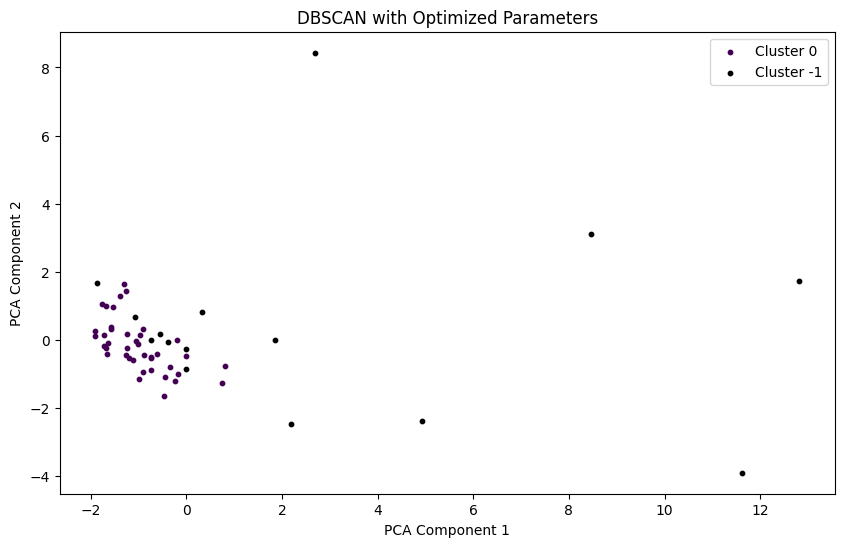

In [319]:
eps_values = np.arange(0.5, 2.5, 0.2)
min_samples_values = [3, 5, 7]
best_dbscan_score = -1
best_dbscan_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_scaled)
        if len(set(dbscan_labels)) > 1:
            score = silhouette_score(X_scaled, dbscan_labels)
            if score > best_dbscan_score:
                best_dbscan_score = score
                best_dbscan_params = {"eps": eps, "min_samples": min_samples}

print(f"Best DBSCAN params: {best_dbscan_params}, Silhouette Score: {best_dbscan_score}")
dbscan = DBSCAN(**best_dbscan_params)
dbscan_labels = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
unique_labels_dbscan = set(dbscan_labels)
colors = [plt.cm.viridis(each) for each in np.linspace(0, 1, len(unique_labels_dbscan))]
for label, color in zip(unique_labels_dbscan, colors):
    if label == -1:  # Szum
        color = [0, 0, 0, 1]
    mask = dbscan_labels == label
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], color=color, label=f"Cluster {label}", s=10)
plt.title('DBSCAN with Optimized Parameters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


# K-MEANS

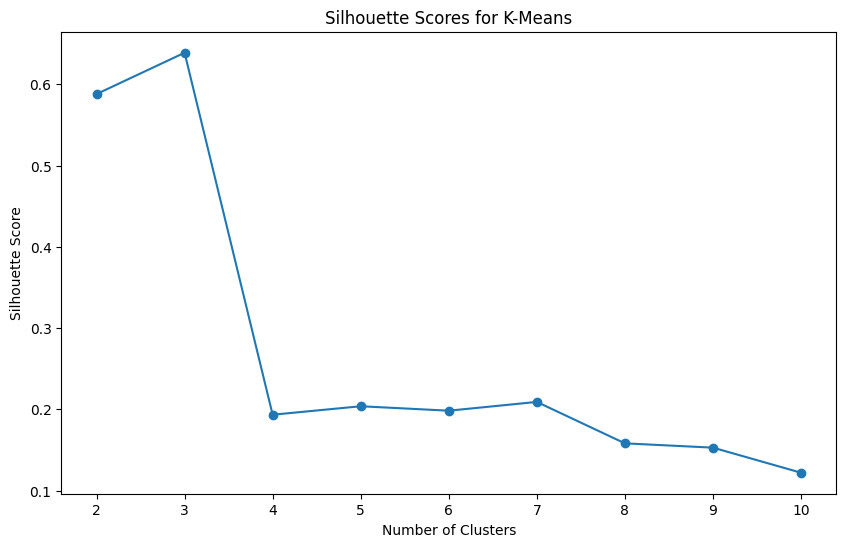

Optimal number of clusters for K-Means: 3


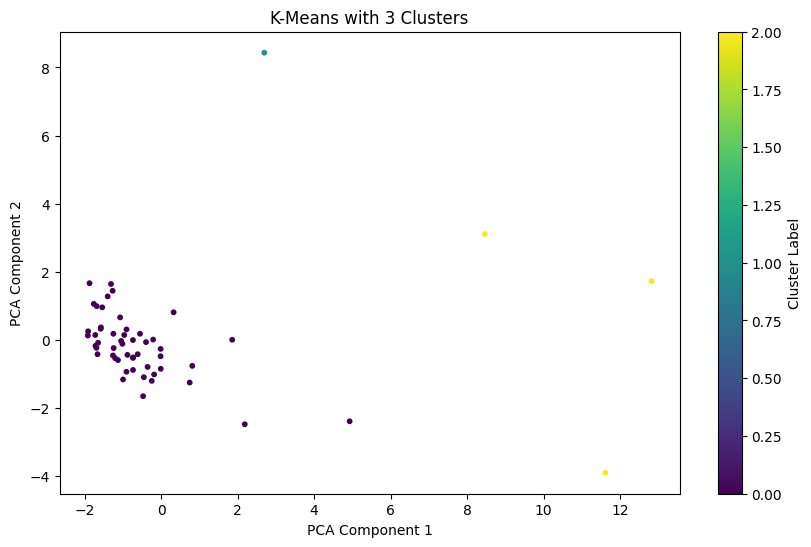

In [320]:
range_clusters = range(2, 11)
silhouette_scores_kmeans = []

for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, kmeans_labels)
    silhouette_scores_kmeans.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range_clusters, silhouette_scores_kmeans, marker='o')
plt.title('Silhouette Scores for K-Means')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

optimal_clusters = range_clusters[np.argmax(silhouette_scores_kmeans)]
print(f"Optimal number of clusters for K-Means: {optimal_clusters}")

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title(f'K-Means with {optimal_clusters} Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


# HIERARCHICAL CLUSTERING

Hierarchical clutstering score: 0.6388061248446019


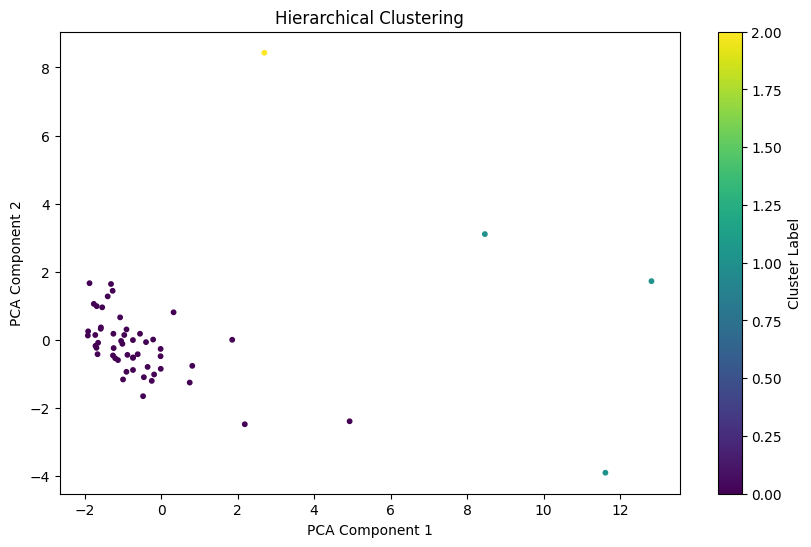

In [321]:
hierarchical = AgglomerativeClustering(n_clusters=optimal_clusters)
hierarchical_labels = hierarchical.fit_predict(X_scaled)
score_h = silhouette_score(X_scaled, hierarchical_labels)

print(f'Hierarchical clutstering score: {score_h}')

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='viridis', s=10)
plt.title('Hierarchical Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# GMM

Hierarchical clutstering score: 0.6388061248446019


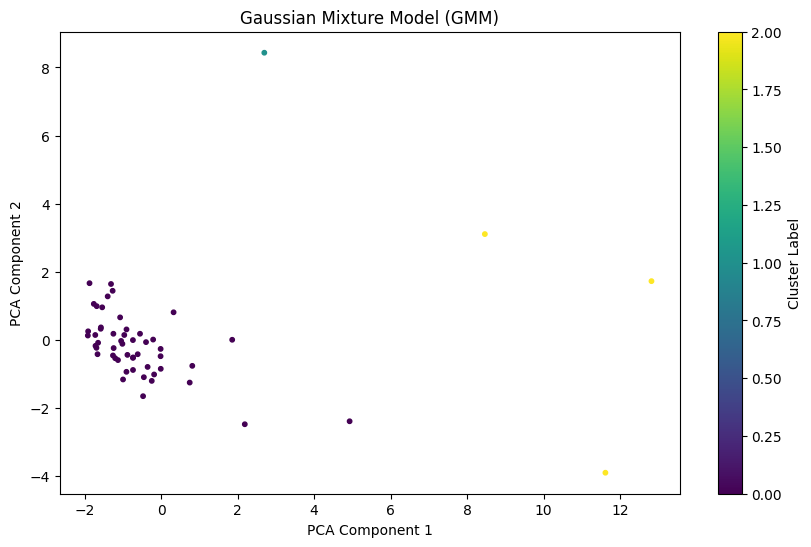

In [322]:
gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

score_gmm = silhouette_score(X_scaled, gmm_labels)

print(f'Hierarchical clutstering score: {score_gmm}')

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis', s=10)
plt.title('Gaussian Mixture Model (GMM)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Clustering - spring, summer, autumn, winter - silhouette score

In [323]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

selected_months = [4, 7, 11, 1]
range_clusters = range(2, 11)

silhouette_scores = {month: [] for month in selected_months}

for month in selected_months:
    data_month = merged_df[merged_df['Miesiac'] == month]
    
    num_cols = data_month.select_dtypes(include='number').columns
    X = data_month[num_cols]
    
    X = X.fillna(X.mean())
    
    X_scaled = StandardScaler().fit_transform(X)
    
    for k in range_clusters:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        silhouette_scores[month].append(score)

for month in selected_months:
    plt.figure(figsize=(8, 5))
    plt.plot(range_clusters, silhouette_scores[month], marker='o', label=f'Month {month}')
    plt.title(f'Silhouette Score for Month {month}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(range_clusters)
    plt.grid(True)
    plt.legend()
    plt.show()


ValueError: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required by StandardScaler.

# Clustering - spring, summer, autumn, winter

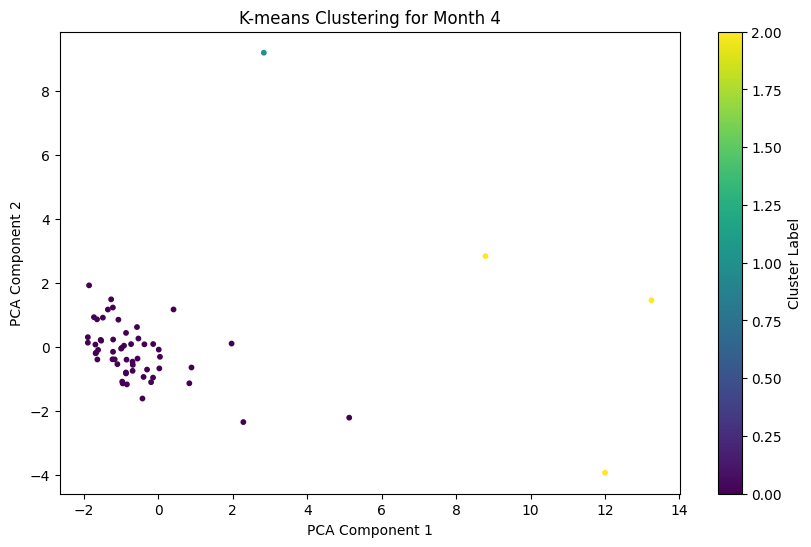

Cluster distribution for Month 4:
0    55
2     3
1     1
Name: count, dtype: int64


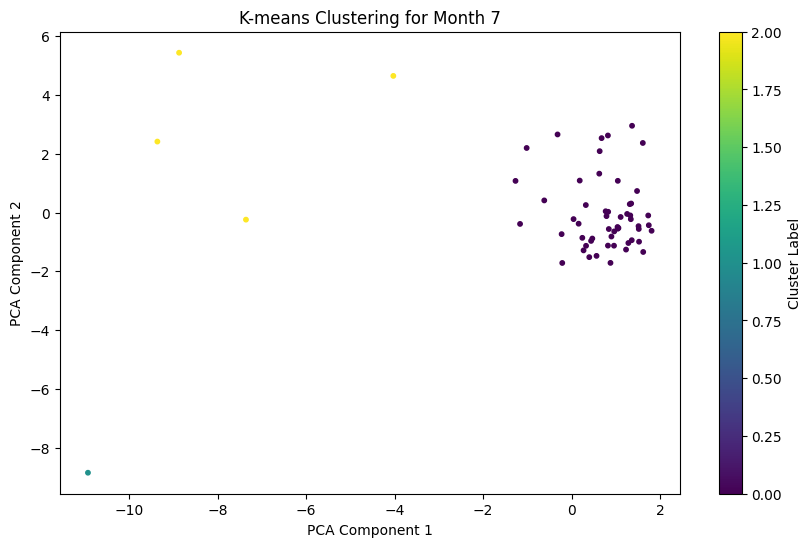

Cluster distribution for Month 7:
0    54
2     4
1     1
Name: count, dtype: int64


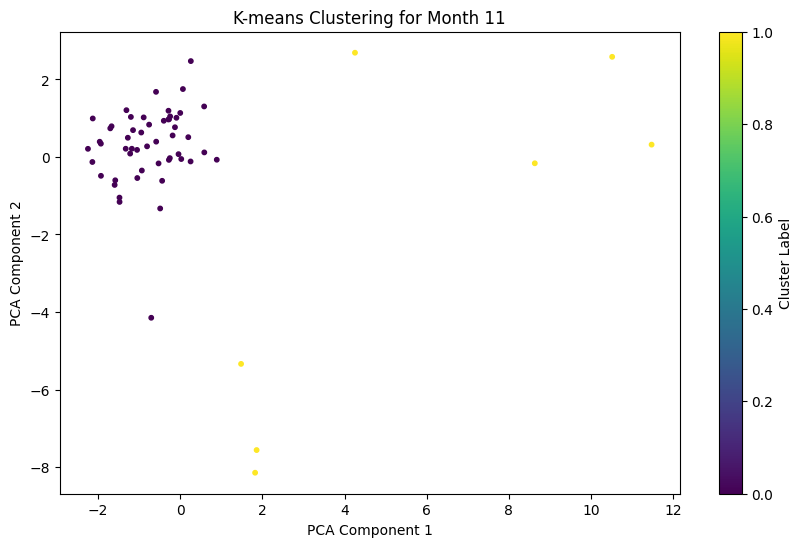

Cluster distribution for Month 11:
0    52
1     7
Name: count, dtype: int64


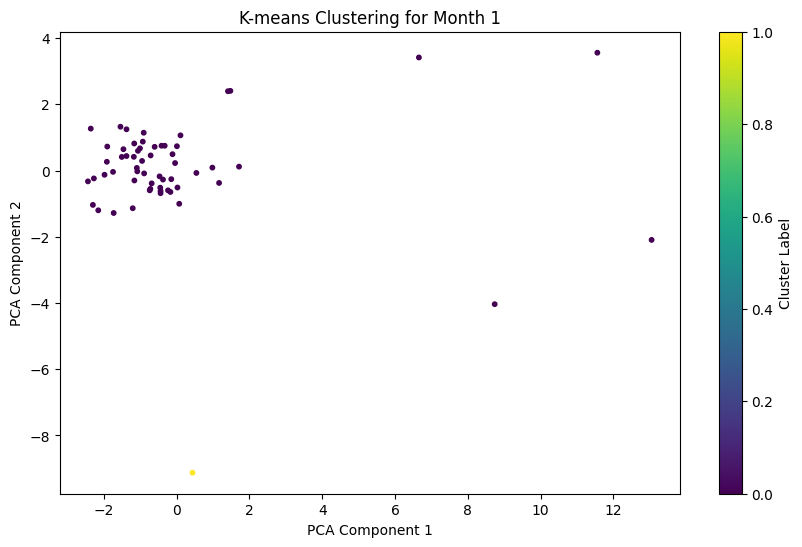

Cluster distribution for Month 1:
0    58
1     1
Name: count, dtype: int64


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

selected_months = [4, 7, 11, 1]
cluster_results = {}

for month in selected_months:
    data_month = merged_df[merged_df['Miesiac'] == month]
    
    num_cols = data_month.select_dtypes(include='number').columns
    X = data_month[num_cols]
    
    X = X.fillna(X.mean())
    
    X_scaled = StandardScaler().fit_transform(X)
    k = 3 if month in (4, 7) else 2
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=10)
    plt.title(f'K-means Clustering for Month {month}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster Label')
    plt.show()
    
    cluster_counts = pd.Series(kmeans_labels).value_counts()
    print(f"Cluster distribution for Month {month}:")
    print(cluster_counts)

    cluster_results[month] = pd.DataFrame({
        'Kod_stacji': data_month['Kod_stacji'].values,
        'Cluster': labels
    })

# Stacje we wspólnych klastrach

In [ ]:
station_pairs_per_month = {}
for month in selected_months:
    df = cluster_results[month]
    pairs = []
    for cluster_label in df['Cluster'].unique():
        cluster_stations = df[df['Cluster'] == cluster_label]['Kod_stacji'].values
        pairs.extend([(a, b) for i, a in enumerate(cluster_stations) for b in cluster_stations[i + 1:]])
    station_pairs_per_month[month] = set(pairs)

common_station_pairs = set.intersection(*station_pairs_per_month.values())

stations_in_common_clusters = set()
for pair in common_station_pairs:
    stations_in_common_clusters.update(pair)

stations_df = pd.DataFrame({'Kod_stacji': list(stations_in_common_clusters)})
stations_with_names = stations_df.merge(merged_df[['Kod_stacji', 'Nazwa_stacji']].drop_duplicates(), on='Kod_stacji')

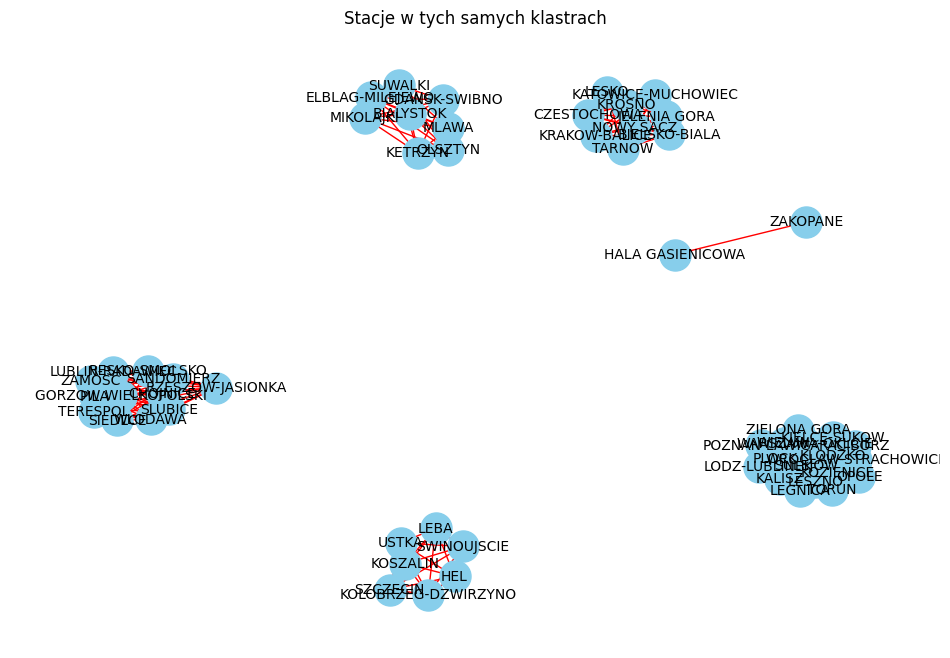

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for _, row in stations_with_names.iterrows():
    G.add_node(row['Nazwa_stacji'], label=row['Nazwa_stacji'])

for pair in common_station_pairs:
    station_a = stations_with_names.loc[stations_with_names['Kod_stacji'] == pair[0], 'Nazwa_stacji'].values[0]
    station_b = stations_with_names.loc[stations_with_names['Kod_stacji'] == pair[1], 'Nazwa_stacji'].values[0]
    G.add_edge(station_a, station_b)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=0.40)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue")
nx.draw_networkx_edges(G, pos, edge_color="red")
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Stacje w tych samych klastrach")
plt.axis("off")
plt.show()


In [ ]:
from collections import defaultdict

station_groups = defaultdict(set)

for pair in common_station_pairs:
    station_groups[pair[0]].add(pair[1])
    station_groups[pair[1]].add(pair[0])

final_groups = []
visited = set()

for station in station_groups.keys():
    if station not in visited:
        group = set()
        to_visit = {station}
        
        while to_visit:
            current = to_visit.pop()
            if current not in visited:
                visited.add(current)
                group.add(current)
                to_visit.update(station_groups[current] - visited)
        
        final_groups.append(group)

final_groups_with_names = [
    {merged_df.loc[merged_df['Kod_stacji'] == station, 'Nazwa_stacji'].values[0] for station in group}
    for group in final_groups
]

for i, group in enumerate(final_groups_with_names, start=1):
    print(f"Zbiór {i}: {', '.join(group)}")


Zbiór 1: OPOLE, LODZ-LUBLINEK, WARSZAWA-OKLCIE, LESZNO, KIELCE-SUKOW, TORUN, WIELUN, WROCLAW-STRACHOWICE, LEGNICA, KOZIENICE, PLOCK, SULEJOW, KALISZ, POZNAN-LAWICA, ZIELONA GORA, RACIBORZ, KLODZKO
Zbiór 2: GORZOW WIELKOPOLSKI, RESKO-SMOLSKO, SIEDLCE, SANDOMIERZ, CHOJNICE, WLODAWA, RZESZOW-JASIONKA, PILA, LUBLIN-RADAWIEC, SLUBICE, ZAMOSC, TERESPOL
Zbiór 3: MLAWA, MIKOLAJKI, SUWALKI, KETRZYN, ELBLAG-MILEJEWO, OLSZTYN, BIALYSTOK, GDANSK-SWIBNO
Zbiór 4: SZCZECIN, KOSZALIN, USTKA, SWINOUJSCIE, HEL, KOLOBRZEG-DZWIRZYNO, LEBA
Zbiór 5: KRAKOW-BALICE, CZESTOCHOWA, NOWY SACZ, KATOWICE-MUCHOWIEC, TARNOW, JELENIA GORA, LESKO, KROSNO, BIELSKO-BIALA
Zbiór 6: HALA GASIENICOWA, ZAKOPANE
